# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


In [2]:
import sys
sys.path.insert(0, '/home/workspace/python/src/')
sys.path.insert(0, '/home/workspace/python/utils/')
from workspace_utils import active_session # prevent notebook connection from dropping during long training session

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 4. Import and Instantiate a DDPG Agent

This code cell imports a DDPG agent that uses an Actor-Critic architecture to interact with and learn from the environment.

This agent's source code was adapted from the **Deep Reinforment Learning** GitHub repo **DDPG Pendulum** and **DDPG Bipedal** projects

In [6]:
#from ddpg_agent_bipedal import Agent
from ddpg_agent_pendulum import Agent

max_steps = 1000
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_workers=num_agents, max_steps=max_steps)
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=132, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


### 5. Function to Train Agent with DDPG

In [7]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

def ddpg(n_episodes=1000, max_t=max_steps, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            score += reward
            for i in range(num_agents):
                agent.step(state[i], action[i], reward[i], next_state[i], done[i])
            state = next_state
            if np.any(done):
                break 
           
        # Bookkeep scores each episode
        score = score.mean()                # mean score across all agents
        scores_deque.append(score)
        scores.append(score)
        mean_score = np.mean(scores_deque)  # mean score across (100) episodes
        
        # Print progress and store checkpoints each episode
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, score), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            
        # Record final data once completion targets reached (Average over 30 for 100 consecutive episodes)
        if mean_score >= 30 and i_episode > 100:
            print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(i_episode, mean_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
            break
            
    return scores


### 6. Train the Agent and Plot Performance

Episode 100	Average Score: 27.53	Score: 36.92
Environment solved in 107 episodes, mean score: 30.05


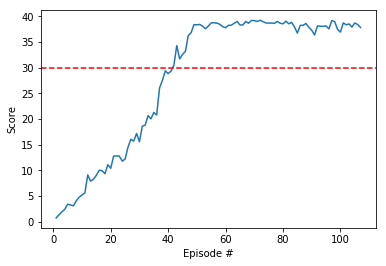

In [8]:
with active_session():
    scores = ddpg()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.axhline(y = 30, color = 'r', linestyle = '--')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 7. Algorithm Design Decisions

There were a few **key implementation changes** to the Udacity's GitHub DRL plain vanilla 'Pendulum' agent model that I arrived at through my local testing:

- Training 20 agents in parallel dramatically improved results compared to a single agent
- Deeper networks did not always mean better results. Compared to hidden layer depth described in Lillicrap's DDPG paper, the agent here performed better with layers of nearly half the size.
* Two FC layers appeared sufficient for the desired performance. More layers introduced other problems like overfitting and increased training time
- Do not update target networks at every time step and perform updates several times at once when doing it
- Do not learn at every time step and draw several times from the replay buffer at each learning step when performed
- Use different learning rates for the actor and critic. The critic 'drives' the actor learning, so its learning rate should be larger so it converges faster
- Use of a small variance in the OU process noise distribution
* Use of normally, rather than uniformly, distributed process noise
- Batch normalization on the first hidden layer of each local network stabilized learning
- 'Long' episode durations to allow more time for score accumulation



### 8. Future Improvements

Compared to the total number of time steps each episode (1000), the performance goal is really not that good. An average score of 30 with a reward of 0.1 per time step means the agent is spending on average 70% of the time outside the goal region. To improve this we could:
- Introduce a more complex network and/or add more agents to contribute to the replay buffer
- Provide additional state information, like raw pixels, to better characterize the target location along with an updated network architecture to include CNNs
- Add an explicit temporal aspect to the environment state by stacking several pixel frames together as the input for each time step
- Introduce other network components like RNNs to further capture temporal relationships between the environment and agent actions